# Cell Oracle cardiac development

With the base GRN output data from `3-tf-binding.ipynb` and scRNAseq data, I use CellOrcale to develop gene regulatory networks.

### 0. Import libraries

In [1]:
# 0. Import

import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

from scipy.io import mmread
from scipy.sparse import csr_matrix

In [3]:
import warnings
warnings.filterwarnings('ignore')
from celloracle import motif_analysis as ma
import celloracle as co
co.__version__

which: no R in (/project/clark-saucerman/bedtools2/bin:/apps/software/standard/core/gcc/12.2.0/bin:/apps/software/standard/core/jupyterlab/3.6.3-py3.11:/apps/software/standard/core/jupyterlab/3.6.3-py3.11/sbin:/apps/software/standard/core/jupyterlab/3.6.3-py3.11/bin:/home/apc5un/bedtools2/bin:/opt/mam/9.1.2/bin:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/opt/slurm/current/bin:/opt/singularity/current/bin:/opt/rci/bin:/share/rci_apps/common/bin:/share/resources/HPCtools:/opt/mam/current/bin:/opt/apptainer/current/bin)


'0.14.0'

In [4]:
# visualization settings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300

### 1. Load and setup data

Load in the scRNAseq data. Set the condition (e.g., WT or KO) and the timepoint (e.g., 85 or 9).

In [31]:
wt_or_ko = 'WT'
timepoint = '85'
adata = sc.read_h5ad(f'data/adata_objects/e{timepoint}_subset.h5ad')

In [32]:
# RAW DATA IN CASE YOU NEED IT
raw_mtx = mmread(f"./data/adata_objects/e{timepoint}_matrix.mtx")
raw_cells = pd.read_csv(f"./data/adata_objects/e{timepoint}_raw_cells.csv", header=None)
raw_genes = pd.read_csv(f"./data/adata_objects/e{timepoint}_raw_genes.csv", header=None)
x = pd.DataFrame(raw_mtx.toarray())
x.index = raw_genes.values.T[0]

In [33]:
adata.X = x.loc[adata.var_names, :].values.T

Below, I have to map the numeric that was output when I transformed the seurat object to anndata. The dictionary provides this mapping.

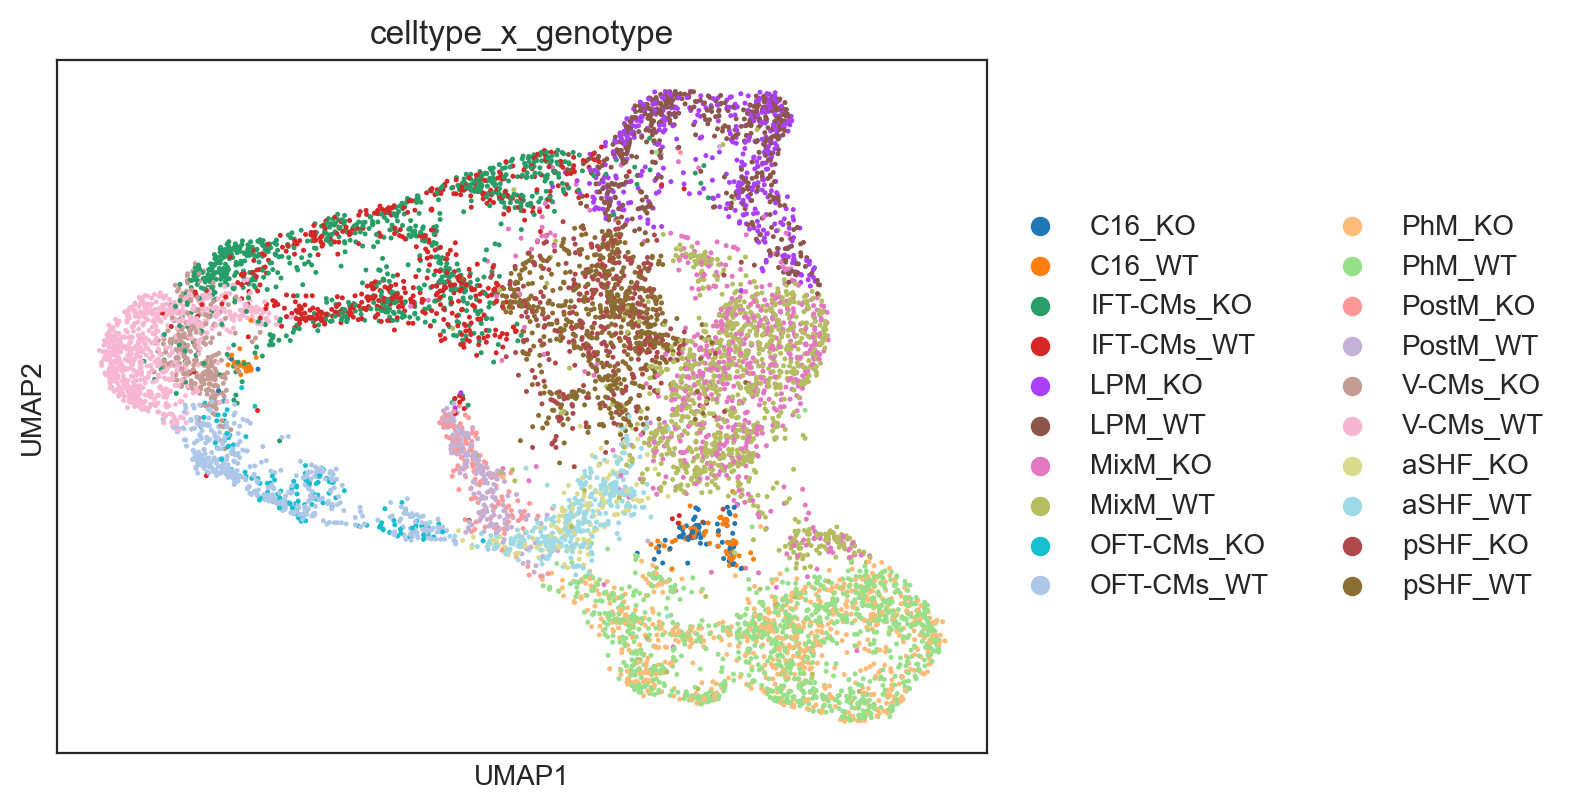

In [36]:
if timepoint == '775':
    e775_names = ['SHF_WT', 'SHF_KO', 'CMs/FHF_WT', 'CMs/FHF_KO', 'JCF_WT', 'JCF_KO', 'CrM_WT', 
                      'CrM_KO', 'ExM_WT', 'ExM_KO', 'SoM_WT', 'SoM_KO', 'LPM_WT', 'LPM_KO', 'NMPs_WT', 
                      'NMPs_KO', 'PrxM_WT', 'PrxM_KO', 'KPs_WT', 'KPs_KO', 'HSCs_WT', 'HSCs_KO']
    mapping_dict = dict(zip(range(0, len(e775_names)), e775_names))
    adata.obs['celltype_x_genotype'] = adata.obs['cell_type_pool_x_genotype'].map(mapping_dict)

if timepoint == '85':
    e85_names = ['pSHF_WT','pSHF_KO', 'aSHF_WT', 'aSHF_KO', 'IFT-CMs_WT', 'IFT-CMs_KO', 'V-CMs_WT', 
                     'V-CMs_KO', 'OFT-CMs_WT', 'OFT-CMs_KO', 'PhM_WT', 'PhM_KO', 'LPM_WT', 'LPM_KO', 
                     'PostM_WT', 'PostM_KO', 'MixM_WT', 'MixM_KO', 'C16_WT', 'C16_KO']
    mapping_dict = dict(zip(range(0, len(e85_names)), e85_names))
    adata.obs['celltype_x_genotype'] = adata.obs['cell_type_pool_x_genotype'].map(mapping_dict)

if timepoint == '9':
    e9_names = ['SHF_WT', 'SHF_KO', 'Pe_WT', 'Pe_KO', 'VP_WT', 'VP_KO', 'CMs-A_WT', 'CMs-A_KO', 
                    'CMs-AVC_WT', 'CMs-AVC_KO', 'CMs-V_WT', 'CMs-V_KO', 'CMs-OFT_WT', 'CMs-OFT_KO', 
                    'PhM_WT', 'PhM_KO', 'C11_WT', 'C11_KO']
    mapping_dict = dict(zip(range(0, len(e9_names)), e9_names))
    adata.obs['celltype_x_genotype'] = adata.obs['cell_type_pool_x_genotype'].map(mapping_dict)


sc.pl.umap(adata, color=['celltype_x_genotype'], use_raw=False)

Here, I subset the cardiomyocyte clusters that I will use for constructing the GRN.

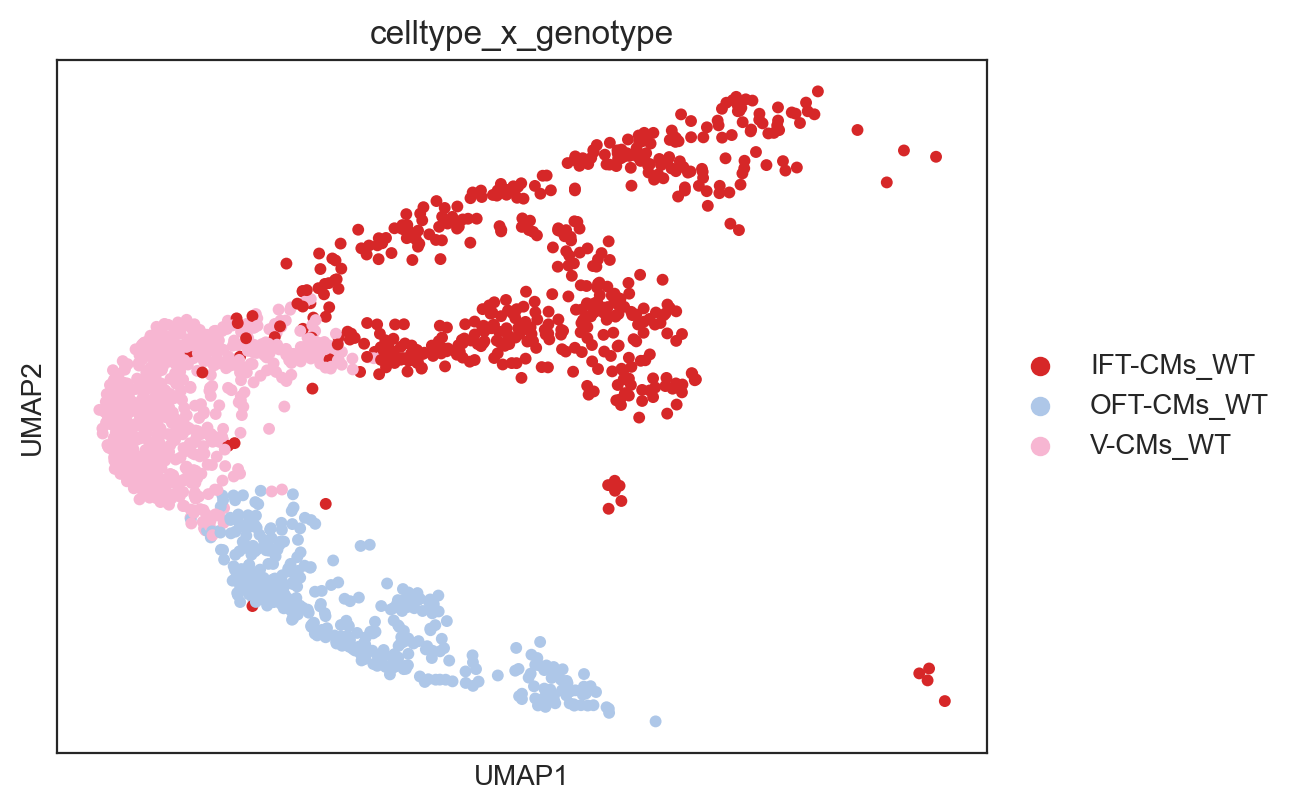

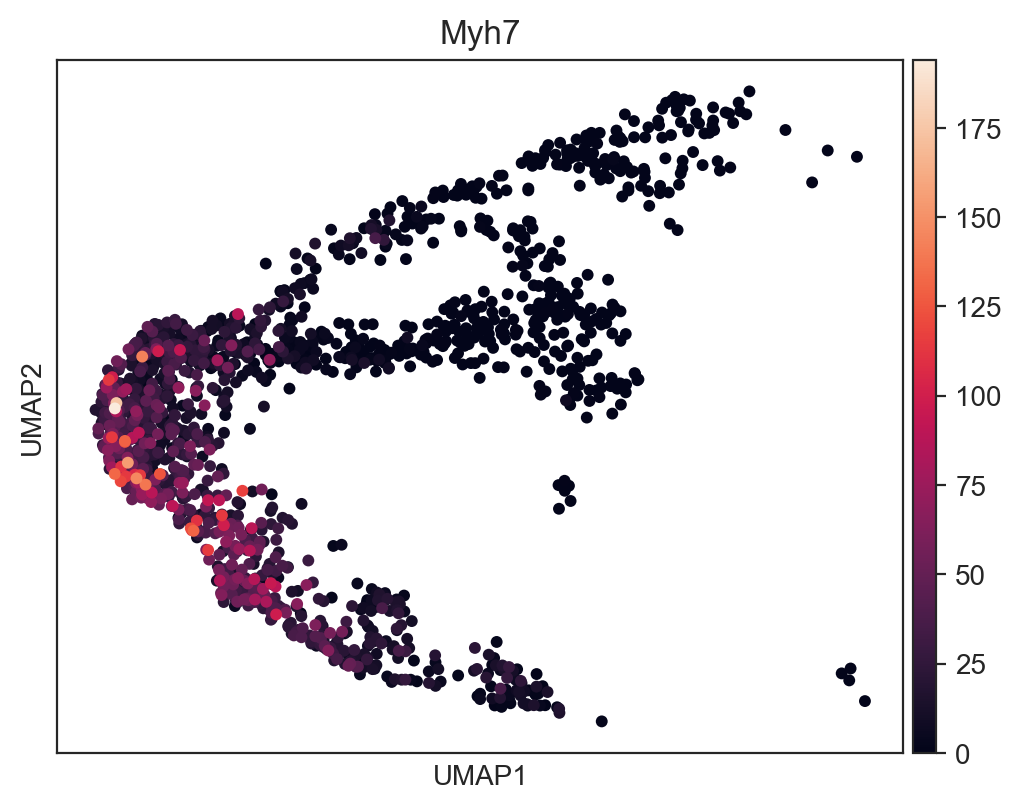

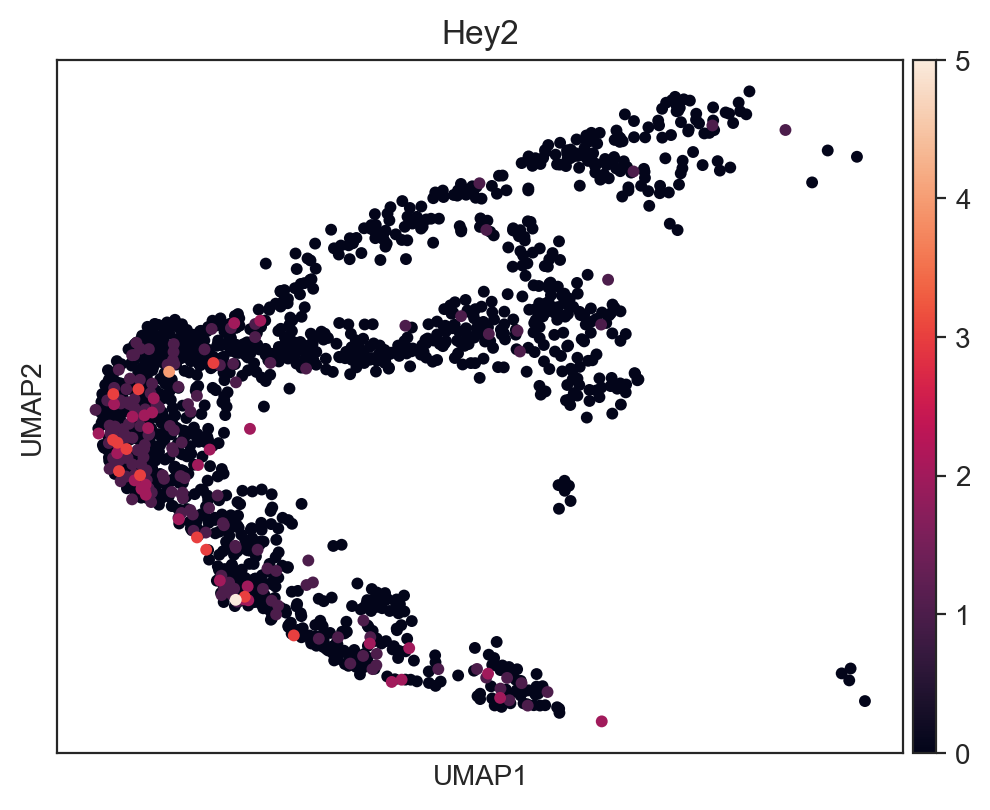

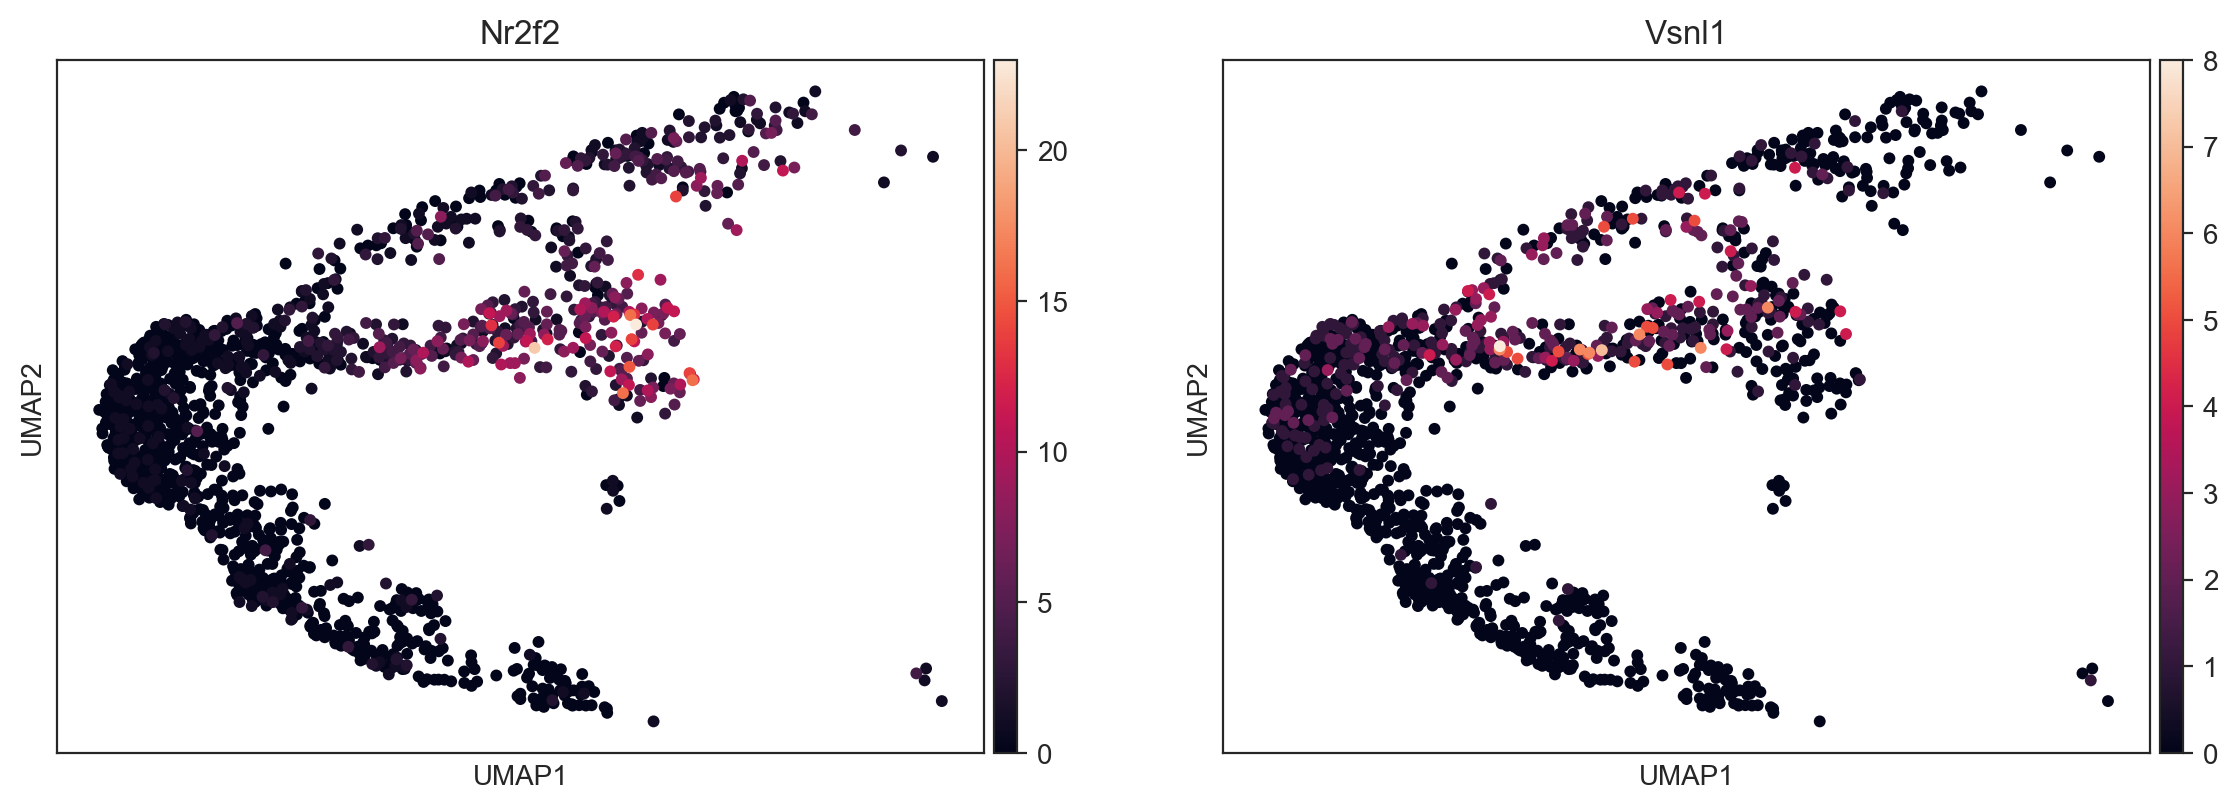

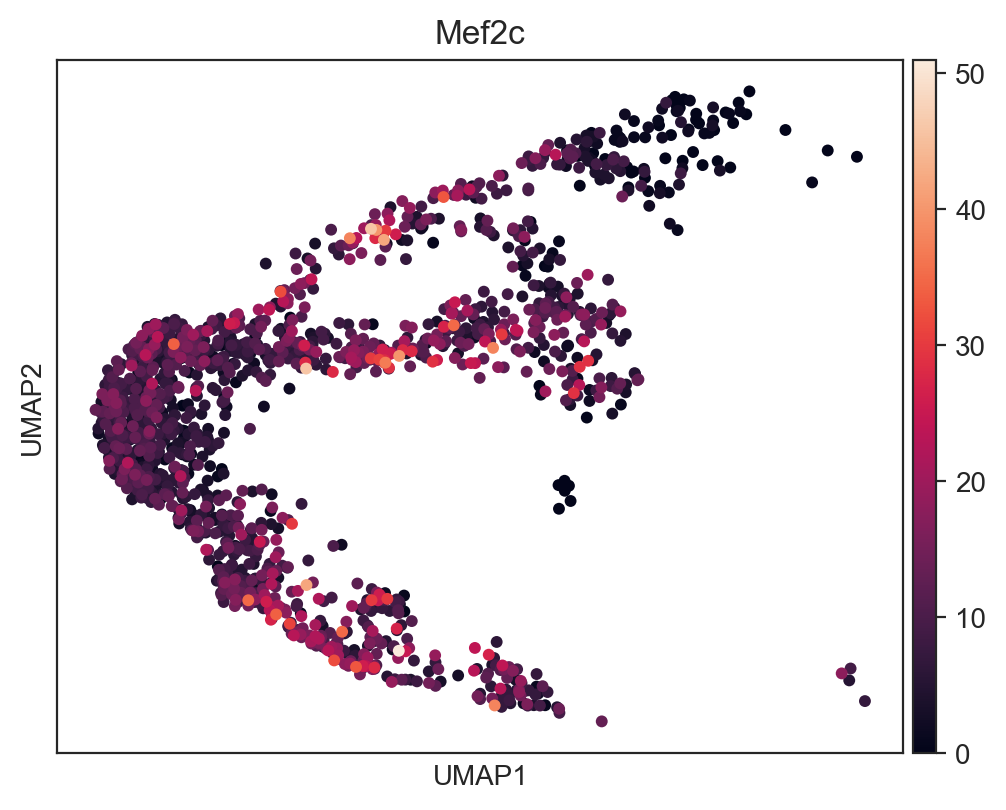

In [37]:
if timepoint == "775":
    adata_sub = adata[adata.obs['celltype_x_genotype'].isin([
            f'SHF_{wt_or_ko}',
            f'CMs/FHF_{wt_or_ko}'
        ]
        )]
    mapping_dict = {f'SHF_{wt_or_ko}': f'HF_{wt_or_ko}',
                    f'CMs/FHF_{wt_or_ko}': f'HF_{wt_or_ko}'}
    adata_sub.obs['celltype_x_genotype'] = adata.obs['celltype_x_genotype'].map(mapping_dict)
    

if timepoint == "85":
    adata_sub = adata[adata.obs['celltype_x_genotype'].isin([
            f'IFT-CMs_{wt_or_ko}',
            f'V-CMs_{wt_or_ko}',
            f'OFT-CMs_{wt_or_ko}',
        ]
        )]
    
if timepoint == "9":
    adata.obs.loc[adata.obs['celltype_x_genotype'] == 'CMs-AVC_WT', 'celltype_x_genotype'] = 'CMs-A_WT'
    adata_sub = adata[adata.obs['celltype_x_genotype'].isin([
            f'CMs-A_{wt_or_ko}',
            f'CMs-OFT_{wt_or_ko}',
            f'CMs-V_{wt_or_ko}'
        ]
        )]

sc.pl.umap(adata_sub, color='celltype_x_genotype')

In [38]:
print(f"Cell number is :{adata_sub.shape[0]}")
print(f"Gene number is :{adata_sub.shape[1]}")

Cell number is :1641
Gene number is :5000


### Load in base GRN

In [62]:
base_GRN = pd.read_parquet(f'data/base_grn_outputs/E{timepoint}/{wt_or_ko}_base_GRN_dataframe.parquet')    

In [64]:
# IF PRUNING DIFF ACCESSIBLE REGIONS

# diffexp = pd.read_csv(f'./data/base_grn_outputs/e{timepoint}{wt_or_ko.lower()}.txt', sep = '\t')
# removed_indexes = []
# for index, row in diffexp.iterrows():
#     if row['Log2FC'] < -1:
#         removed_indexes.append(f"{row['seqnames']}_{row['start']}_{row['end']}")                
# len(removed_indexes)
# base_GRN = base_GRN[~base_GRN.peak_id.isin(removed_indexes)]

86

## 2. Make Oracle object
We will use an Oracle object during the data preprocessing and GRN inference steps. Using its internal functions, the Oracle object computes and stores all of the necessary information for these calculations. To begin, we will instantiate a new Oracle object and input our gene expression data (anndata) and TF info (base GRN).

In [43]:
oracle = co.Oracle()

In [44]:
oracle.import_anndata_as_raw_count(adata=adata_sub,
                                   cluster_column_name="celltype_x_genotype",
                                   embedding_name="X_umap")
oracle

5000 genes were found in the adata. Note that Celloracle is intended to use around 1000-3000 genes, so the behavior with this number of genes may differ from what is expected.


Oracle object

Meta data
    celloracle version used for instantiation: 0.14.0
    n_cells: 1641
    n_genes: 5000
    cluster_name: celltype_x_genotype
    dimensional_reduction_name: X_umap
    n_target_genes_in_TFdict: 0 genes
    n_regulatory_in_TFdict: 0 genes
    n_regulatory_in_both_TFdict_and_scRNA-seq: 0 genes
    n_target_genes_both_TFdict_and_scRNA-seq: 0 genes
    k_for_knn_imputation: NA
Status
    Gene expression matrix: Ready
    BaseGRN: Not imported
    PCA calculation: Not finished
    Knn imputation: Not finished
    GRN calculation for simulation: Not finished

In [45]:
# You can load TF info dataframe with the following code.
oracle.import_TF_data(TF_info_matrix=base_GRN)

### 3. KNN imputation

CellOracle uses the same strategy as velocyto for visualizing cell transitions. This process requires KNN imputation in advance.

For the KNN imputation, we first need to calculate and select PCs.

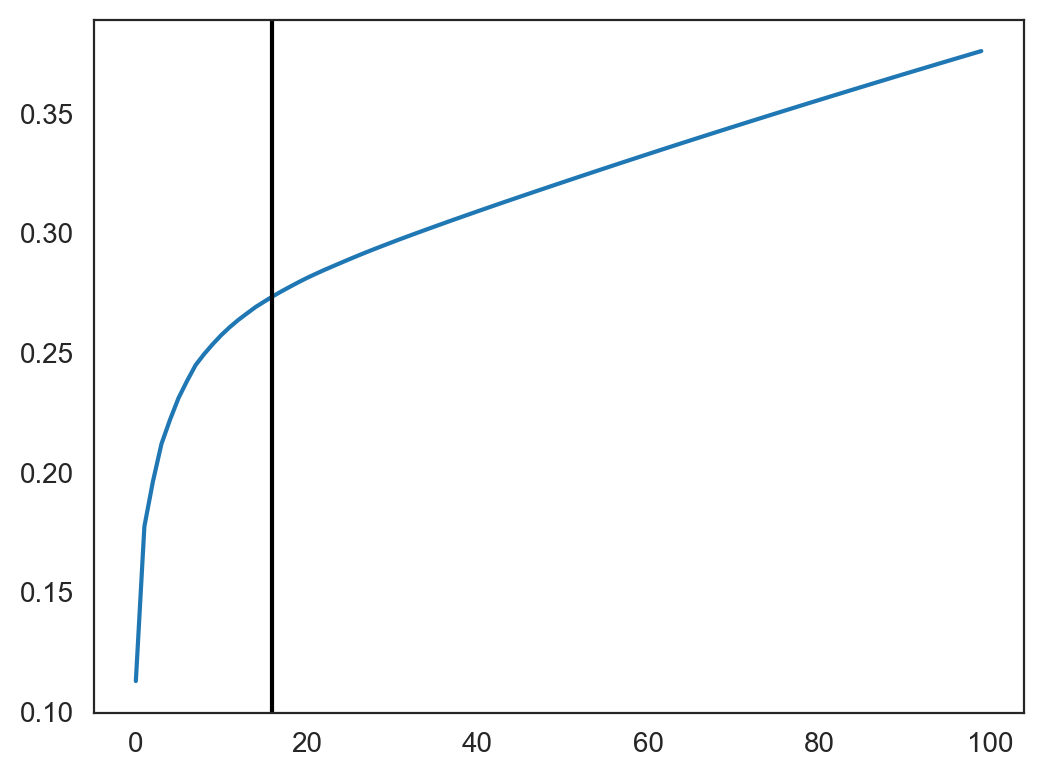

16


In [46]:
# Perform PCA
oracle.perform_PCA()

# Select important PCs
plt.plot(np.cumsum(oracle.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(oracle.pca.explained_variance_ratio_))>0.002))[0][0]
plt.axvline(n_comps, c="k")
plt.show()
print(n_comps)
n_comps = min(n_comps, 50)

In [47]:
n_cell = oracle.adata.shape[0]
print(f"cell number is :{n_cell}")
k = int(0.025*n_cell)
print(f"Auto-selected k is :{k}")

cell number is :1641
Auto-selected k is :41


In [48]:
oracle.knn_imputation(n_pca_dims=n_comps, k=k, balanced=True, b_sight=k*8,
                      b_maxl=k*4, n_jobs=4)

### 4. Save and Load.

You can save your Oracle object using Oracle.to_hdf5(FILE_NAME.celloracle.oracle).

Pleasae use co.load_hdf5(FILE_NAME.celloracle.oracle) to load the saved file.

In [49]:
# Save oracle object.
oracle.to_hdf5(f"./data/celloracle/e{timepoint}/{wt_or_ko}_cardiac-subset.celloracle.oracle")

In [50]:
# Load file.
oracle = co.load_hdf5(f"./data/celloracle/e{timepoint}/{wt_or_ko}_cardiac-subset.celloracle.oracle")

### 5. GRN calculation
The next step constructs a cluster-specific GRN for all clusters.

You can calculate GRNs with the get_links function, and it will return the results as a Links object. The Links object stores the inferred GRNs and the corresponding metadata. Most network structure analysis is performed with the Links object.

A GRN will be calculated for each cluster/sub-group. In the example below, we construct GRN for each unit of the “Celltype1_2” clustering.

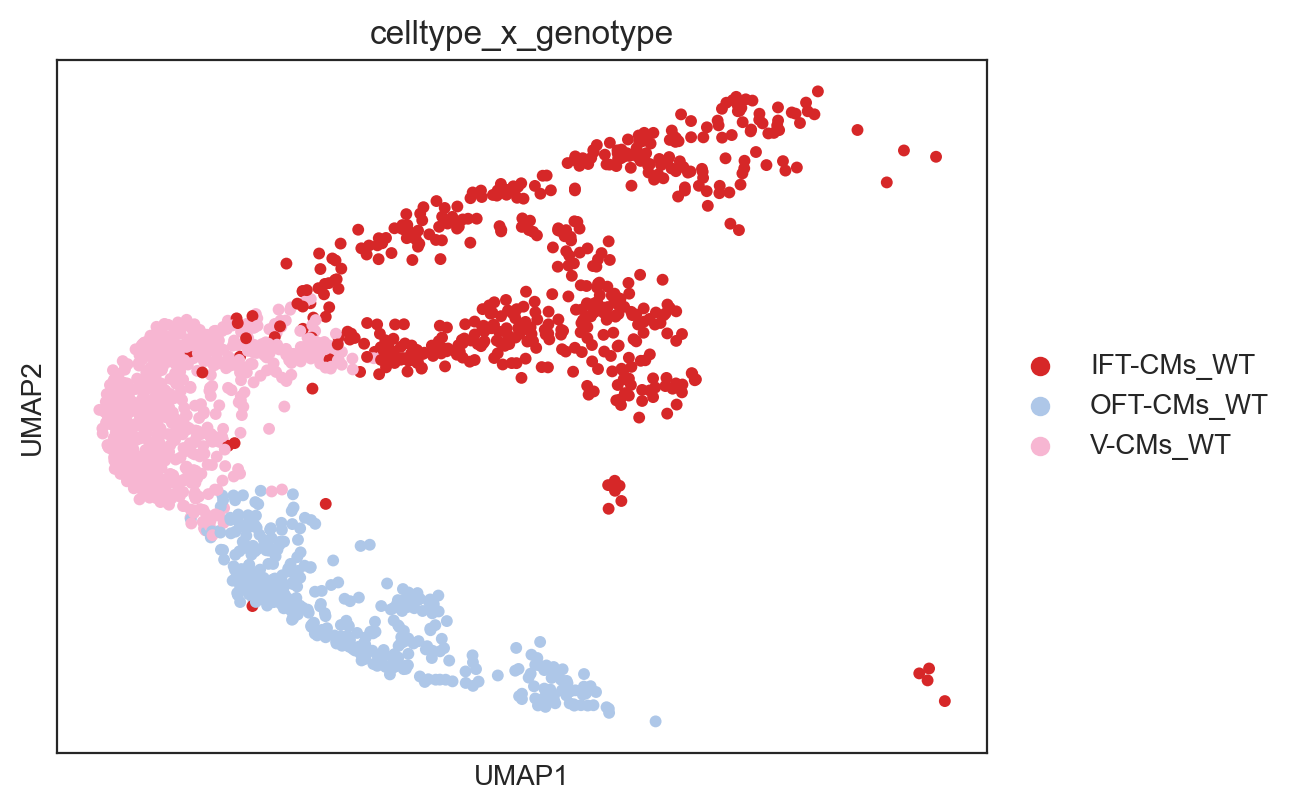

AnnData object with n_obs × n_vars = 1641 × 5000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Sample_Number', 'Sample_Name', 'Genotype', 'percent.mt', 'percent.rib', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.4', 'seurat_clusters', 'harmony_cell_type', 'SCT_snn_res.1', 'harmony_cell_type_subset', 'harmony_cell_type_subset_pool', 'cell_type_pool_x_genotype', 'celltype_x_genotype'
    var: 'features', 'symbol', 'isin_top1000_var_mean_genes', 'isin_TFdict_targets', 'isin_TFdict_regulators'
    uns: 'neighbors', 'celltype_x_genotype_colors', 'log1p'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    varm: 'HARMONY', 'PCs'
    layers: 'raw_count', 'normalized_count', 'imputed_count'
    obsp: 'distances'

In [51]:
# Check clustering data
sc.pl.umap(oracle.adata, color="celltype_x_genotype")
oracle.adata

In [52]:
%%time
# Calculate GRN for each population in "louvain_annot" clustering unit.
# This step may take some time.(~30 minutes)
links = oracle.get_links(cluster_name_for_GRN_unit="celltype_x_genotype", alpha=10,
                         verbose_level=10)

  0%|          | 0/3 [00:00<?, ?it/s]

Inferring GRN for IFT-CMs_WT...


  0%|          | 0/4590 [00:00<?, ?it/s]

Inferring GRN for OFT-CMs_WT...


  0%|          | 0/4590 [00:00<?, ?it/s]

Inferring GRN for V-CMs_WT...


  0%|          | 0/4590 [00:00<?, ?it/s]

CPU times: user 13min, sys: 4.55 s, total: 13min 5s
Wall time: 13min 58s


In [53]:
links.filter_links(p=0.001, weight="coef_abs", threshold_number=4000)

In [54]:
if timepoint == 'E775':
    links.filtered_links[f'HF_{wt_or_ko}']

In [55]:
#./data/celloracle/ network scores.
links.get_network_score()
links.merged_score.head()

,degree_all,degree_centrality_all,degree_in,degree_centrality_in,degree_out,degree_centrality_out,betweenness_centrality,eigenvector_centrality,cluster
Etv5,49,0.035845,0,0.000000,49,0.035845,0.0,0.115107,IFT-CMs_WT
Ankrd1,8,0.005852,8,0.005852,0,0.000000,0.0,0.093024,IFT-CMs_WT
Mef2c,149,0.108998,12,0.008778,137,0.100219,11356.0,0.489766,IFT-CMs_WT
Erbb4,15,0.010973,15,0.010973,0,0.000000,0.0,0.242971,IFT-CMs_WT
Tead1,29,0.021214,2,0.001463,27,0.019751,1309.0,0.138801,IFT-CMs_WT


In [56]:
links.to_hdf5(file_path=f"./data/celloracle/e{timepoint}/{wt_or_ko}_cardiac-subset-links.celloracle.links")